In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/ADL final project/data/final_input.csv', index_col = [0])
df.head()

,Open,Close,High,Low,Volume_x,Volume_y,MA,Returns,BBand_upper,BBand_middle,BBand_lower,Average Directional Index,Directional Index,MACD,MACD_signal,MACD hist,stochastic k,stochastic d,movement
0,297.3300,297.325,297.3300,297.3250,0.0225,0.0400,297.035000,0.000388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,297.2400,297.165,297.2400,297.1600,0.1050,0.0412,297.132857,0.000329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,297.9000,297.660,297.9250,297.5145,3.0150,2.6786,297.265714,0.000447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,297.6695,297.785,297.8155,297.5945,3.1800,2.8610,297.403214,0.000462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,297.7850,297.815,297.9255,297.6850,3.0375,2.3263,297.468214,0.000219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [3]:
train_size = int(len(df) * .7)
df_train =  df.iloc[:train_size]
df_val = df.iloc[train_size:]

print(len(df_train), len(df_val))

65218 27951


In [4]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

feature_columns = ['Open', 'High', 'Low', 'Volume_x', 'Volume_y', 'MA', 'Returns',
       'BBand_upper', 'BBand_middle', 'BBand_lower', 'Directional Index',
       'Average Directional Index', 'MACD', 'MACD_signal', 'MACD hist',
        'stochastic k', 'stochastic d']
      
for feature in feature_columns:
  df_train[feature] = scaler.fit_transform(df_train[[feature]].values)
  df_val[feature] = scaler.transform(df_val[[feature]])

In [5]:
from tensorflow.keras.utils import to_categorical

Y_train = df_train['movement']
Y_val = df_val['movement']

print(len(Y_train[Y_train == 1]), len(Y_train[Y_train == 0]))
print(len(Y_val[Y_val == 1]), len(Y_val[Y_val == 0]))

Y_train = to_categorical(Y_train, 2)
Y_val = to_categorical(Y_val, 2)

34209 31009
14165 13786


In [6]:
df_train = df_train.dropna()
df_train.index = np.arange(0,len(df_train))
df_val.index = np.arange(0,len(df_val))

df_train = df_train[feature_columns]
df_val  = df_val[feature_columns]

In [7]:
def convert_raw_samples_to_model_samples(scd_log_rtns, movements, window_size):
    X, y = [], []
    len_log_rtns = len(scd_log_rtns)
    for i in range(window_size, len_log_rtns):
        X.append(scd_log_rtns[i-window_size:i])
        y.append(movements[i])
    X, y = np.asarray(X), np.asarray(y)
    #X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y


In [8]:
window_size = 256
X_train, y_train = convert_raw_samples_to_model_samples(df_train, Y_train, window_size)
X_val, y_val = convert_raw_samples_to_model_samples(df_val, Y_val, window_size)
#X_test, y_test = convert_raw_samples_to_model_samples(test_values, test_y_values, window_size)

## Embedding

Reference: [paper](https://arxiv.org/pdf/1907.05321.pdf), [code](https://github.com/JanSchm/CapMarket)

In [9]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [11]:
# -*- coding: utf-8 -*-
"""Confusion matrix.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1dbeSXmnx5b6mUMXXYMlYVw-V20-fDdPc
"""

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## LSTM with Attention

In [12]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [13]:
#Attention

def create_LSTM_attention(X, classification, embedding):
  input_seq = Input(shape = (X.shape[1], X.shape[2]))
  attn_layer = Attention(10)

  if embedding:
    time_embedding = Time2Vector(X.shape[1])
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    lstm, state_c, state_h = LSTM(64, return_sequences= True, return_state = True)(x)

  else:
    lstm, state_c, state_h = LSTM(64, return_sequences= True, return_state = True)(input_seq)

  if classification:
    x, attention_weights = attn_layer(lstm, state_h)
    x = Dense(128, activation = 'relu')(x)
    #out = Dense(1, activation = 'softmax')(x)
    out = Dense(2, activation="softmax", name="output")(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-4), metrics = ['acc',f1_m,precision_m, recall_m])

  else:
    vector, attention_weights = attn_layer(lstm, state_h)
    dense1 = Dense(20, activation="relu")(vector)
    dropout = Dropout(0.1)(dense1)
    out = Dense(1)(dropout)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'mse', optimizer = 'Adam', metrics = ['mae', 'mape'])
  return model

In [14]:
#With Time Embedding
lstm_attention_time = create_LSTM_attention(X_train, True, True)
lstm_attention_notime = create_LSTM_attention(X_train, True, False)

In [15]:
history_time = lstm_attention_time.fit(X_train, y_train,epochs=5, validation_data=(X_val, y_val))
history_notime = lstm_attention_notime.fit(X_train, y_train,epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
2030/2030 [==============================] - 324s 158ms/step - loss: 0.6778 - acc: 0.5382 - f1_m: 0.5382 - precision_m: 0.5382 - recall_m: 0.5382 - val_loss: 1.0107 - val_acc: 0.4978 - val_f1_m: 0.4976 - val_precision_m: 0.4976 - val_recall_m: 0.4976
Epoch 2/5
2030/2030 [==============================] - 343s 169ms/step - loss: 0.3446 - acc: 0.8470 - f1_m: 0.8470 - precision_m: 0.8470 - recall_m: 0.8470 - val_loss: 1.1544 - val_acc: 0.5030 - val_f1_m: 0.5029 - val_precision_m: 0.5029 - val_recall_m: 0.5029
Epoch 3/5
2030/2030 [==============================] - 344s 169ms/step - loss: 0.3275 - acc: 0.8523 - f1_m: 0.8523 - precision_m: 0.8523 - recall_m: 0.8523 - val_loss: 1.2325 - val_acc: 0.5020 - val_f1_m: 0.5019 - val_precision_m: 0.5019 - val_recall_m: 0.5019
Epoch 4/5
2030/2030 [==============================] - 353s 174ms/step - loss: 0.3169 - acc: 0.8579 - f1_m: 0.8579 - precision_m: 0.8579 - recall_m: 0.8579 - val_loss: 1.3366 - val_acc: 0.4985 - val_f1_m: 0.4984 - val

In [16]:
y_pred_time = lstm_attention_time.predict(X_val)
y_pred_notime = lstm_attention_notime.predict(X_val)

y_pred_time = [y_pred_time[i].argmax() for i in range(len(y_pred_time))]
y_pred_notime = [y_pred_notime[i].argmax() for i in range(len(y_pred_notime))]



In [17]:
from sklearn.metrics import classification_report
y_true =  [y_val[i].argmax() for i in range(len(y_val))]
print('with Embedding')
print(classification_report(y_true, y_pred_time))
print('--------------------------')
print('without Embedding')
print(classification_report(y_true, y_pred_notime))

with Embedding
              precision    recall  f1-score   support

           0       0.49      0.45      0.47     13679
           1       0.51      0.55      0.53     14016

    accuracy                           0.50     27695
   macro avg       0.50      0.50      0.50     27695
weighted avg       0.50      0.50      0.50     27695

--------------------------
without Embedding
              precision    recall  f1-score   support

           0       0.49      0.43      0.46     13679
           1       0.50      0.57      0.53     14016

    accuracy                           0.50     27695
   macro avg       0.50      0.50      0.49     27695
weighted avg       0.50      0.50      0.50     27695



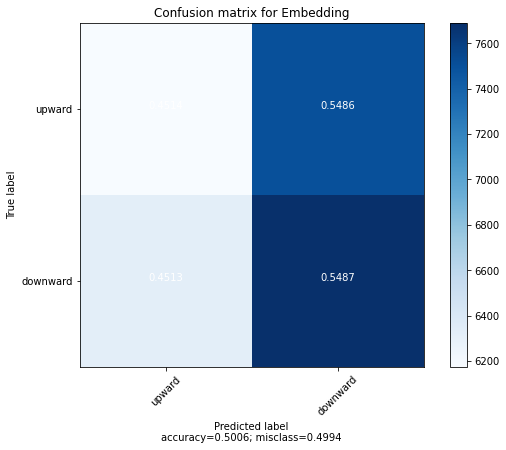

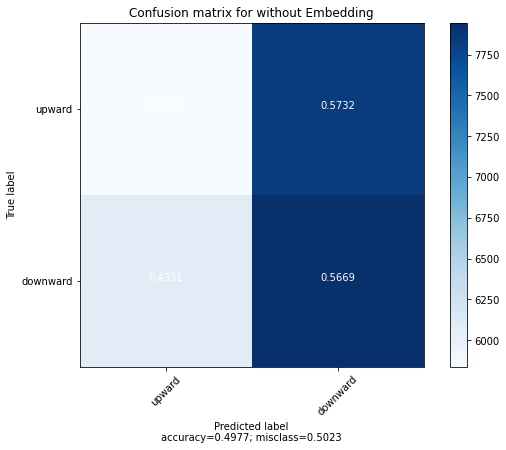

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_time)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix for Embedding',
                      cmap=None,
                      normalize=True)

cm = confusion_matrix(y_true, y_pred_notime)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix for without Embedding',
                      cmap=None,
                      normalize=True)

In [19]:
final_result = pd.DataFrame()
final_result['y_true'] = y_true
final_result['attention_with_time'] = y_pred_time
final_result['attention_without_time'] = y_pred_notime
final_result.to_csv('/content/drive/MyDrive/ADL final project/data/attention_output.csv')